# 라이브러리 불러오기

In [ ]:
!apt -qq -y install fonts-nanum

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 한글폰트 설정
plt.rc("font", family="NanumGothic")
plt.rcParams["axes.unicode_minus"] = False
sns.set(style="whitegrid", palette="pastel", font_scale=1.1)

# 데이터 불러오기

In [ ]:
url = "https://raw.githubusercontent.com/s0nghyunje0ng/2025-weather-bigdata-contest/safety/topic2_safety/data/processed/call119_preprocessed_D_spatial_then_neighbor.csv"

df_call = pd.read_csv(url)

In [5]:
df_call["tm"] = pd.to_datetime(df_call["tm"])

# `2020-09-03` 처리

일별 신고 건수가 2,300건 이상으로 압도적 ← 자연재해 등 외부 요인이 개입되었을 가능성 높음

## `is_disaster` 플래그 추가

In [6]:
df_call_with_disaster = df_call.copy()
df_call_with_disaster["is_disaster"] = df_call_with_disaster["tm"] == pd.Timestamp("2020-09-03")

print(f"df_call_with_disaster {df_call_with_disaster.shape}")
df_call_with_disaster.head(3)

df_call_with_disaster (42924, 14)


,tm,address_gu,sub_address,stn,ta_max,ta_min,ta_max_min,hm_max,hm_min,ws_max,ws_ins_max,rn_day,call_count,is_disaster
0,2020-05-01,강서구,강서구 대저2동,904,23.7,16.6,7.1,90.3,63.2,5.8,10.6,0.0,1,False
1,2020-05-01,강서구,강서구 천성동,921,24.3,15.4,8.9,96.4,64.2,4.8,8.6,0.0,1,False
2,2020-05-01,금정구,금정구 금사동,940,25.6,17.2,8.4,76.4,46.6,4.8,8.3,0.0,1,False


## 제거

In [7]:
df_call_without_disaster = df_call[df_call["tm"] != pd.Timestamp("2020-09-03")].copy()

print(f"전체 {len(df_call)}행 중 2020년 9월 3일에 해당하는 {len(df_call) - len(df_call_without_disaster)}개의 행이 제거되어 {len(df_call_without_disaster)}행이 남았습니다.")
print(f"제거된 데이터는 전체 데이터의 약 {(len(df_call) - len(df_call_without_disaster)) / len(df_call) * 100:.2f}%에 해당합니다.")

전체 42924행 중 2020년 9월 3일에 해당하는 126개의 행이 제거되어 42798행이 남았습니다.
제거된 데이터는 전체 데이터의 약 0.29%에 해당합니다.


# 부산시 전체 하루 신고량 합계 기준 `is_spike_day`

부산시 전체 하루 신고량 합계

In [8]:
daily_calls = df_call.groupby("tm")[["call_count"]].sum()

In [9]:
daily_calls.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 736 entries, 2020-05-01 to 2023-10-31
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   call_count  736 non-null    int64
dtypes: int64(1)
memory usage: 11.5 KB


## IQR 기준

- Q3 + 1.5 * IQR을 기준으로 스파이크 판단

    → 이상치 탐지에 흔히 사용됨

In [10]:
q1_d = daily_calls["call_count"].quantile(0.25)
q3_d = daily_calls["call_count"].quantile(0.75)
iqr_d = q3_d - q1_d
threshold_iqr_d = q3_d + 1.5 * iqr_d

daily_calls["daily_spike_iqr"] = daily_calls["call_count"] > threshold_iqr_d

print(f"[IQR 기준]")
print(f"- 기준 임계값: {threshold_iqr_d:.2f}건 초과")
print(f"- 스파이크 판별 일수: {daily_calls['daily_spike_iqr'].sum()}일 / {len(daily_calls)}일 ({daily_calls['daily_spike_iqr'].sum() / len(daily_calls):.2%})")

[IQR 기준]
- 기준 임계값: 159.38건 초과
- 스파이크 판별 일수: 28일 / 736일 (3.80%)


## 평균 + 표준편차 기준

- 평균 + n * 표준편차를 기준으로 스파이크 판단

    → 정규분포 가정 하에 유효

In [11]:
mean_d = daily_calls["call_count"].mean()
std_d = daily_calls["call_count"].std()
threshold_std_d = mean_d + 3 * std_d

daily_calls["daily_spike_mean_std"] = daily_calls["call_count"] > threshold_std_d

print(f"[평균 + 3σ 기준]")
print(f"- 기준 임계값: {threshold_std_d:.2f}건 초과")
print(f"- 스파이크 판별 일수: {daily_calls['daily_spike_mean_std'].sum()}일 / {len(daily_calls)}일 ({daily_calls['daily_spike_mean_std'].sum() / len(daily_calls):.2%})")

[평균 + 3σ 기준]
- 기준 임계값: 390.80건 초과
- 스파이크 판별 일수: 4일 / 736일 (0.54%)


## 이동평균 대비 급증 기준

- 직전 7일 이동평균 대비 n배를 기준으로 스파이크 판단

    → 일시적 폭증 탐지에 효과적

In [12]:
rolling_mean_d = daily_calls["call_count"].rolling(window=7, center=True, min_periods=1).mean()
rolling_std_d = daily_calls["call_count"].rolling(window=7, center=True, min_periods=1).std()
threshold_moving_d = rolling_mean_d + 2 * rolling_std_d

daily_calls["daily_spike_moving_avg"] = daily_calls["call_count"] > threshold_moving_d

print(f"[이동평균 + 2σ 기준]")
print("- 기준은 일자별로 상이하게 계산되며, 아래는 일부 예시입니다:")
print((threshold_moving_d.head().round(2)).to_string())
print(f"- 스파이크 판별 일수: {daily_calls['daily_spike_moving_avg'].sum()}일 / {len(daily_calls)}일 ({daily_calls['daily_spike_moving_avg'].sum() / len(daily_calls):.2%})")

[이동평균 + 2σ 기준]
- 기준은 일자별로 상이하게 계산되며, 아래는 일부 예시입니다:
tm
2020-05-01    105.14
2020-05-02    104.17
2020-05-03    104.59
2020-05-04    102.43
2020-05-05    106.55
- 스파이크 판별 일수: 10일 / 736일 (1.36%)


## 상위 백분위수 기준

- 신고량 상위 10%를 기준으로 스파이크 판단

- 신고량 상위 5%를 기준으로 스파이크 판단

In [13]:
q90_d = daily_calls["call_count"].quantile(0.90)
q95_d = daily_calls["call_count"].quantile(0.95)

daily_calls["daily_spike_top10pct"] = daily_calls["call_count"] > q90_d
daily_calls["daily_spike_top5pct"] = daily_calls["call_count"] > q95_d

print(f"[상위 10% 기준]")
print(f"- 기준 임계값: {q90_d:.2f}건 초과")
print(f"- 스파이크 판별 일수: {daily_calls['daily_spike_top10pct'].sum()}일 / {len(daily_calls)}일 ({daily_calls['daily_spike_top10pct'].sum() / len(daily_calls):.2%})")
print(f"\n[상위 5% 기준]")
print(f"- 기준 임계값: {q95_d:.2f}건 초과")
print(f"- 스파이크 판별 일수: {daily_calls['daily_spike_top5pct'].sum()}일 / {len(daily_calls)}일 ({daily_calls['daily_spike_top5pct'].sum() / len(daily_calls):.2%})")

[상위 10% 기준]
- 기준 임계값: 138.00건 초과
- 스파이크 판별 일수: 72일 / 736일 (9.78%)

[상위 5% 기준]
- 기준 임계값: 155.00건 초과
- 스파이크 판별 일수: 34일 / 736일 (4.62%)


In [14]:
daily_calls.sum()

,0
call_count,82275
daily_spike_iqr,28
daily_spike_mean_std,4
daily_spike_moving_avg,10
daily_spike_top10pct,72
daily_spike_top5pct,34


# 군/구별 하루 신고량 합계 기준 `is_spike_local`

군/구별 하루 신고량 합계

In [15]:
local_calls = df_call.groupby(["tm", "address_gu"])[["call_count"]].sum()

In [16]:
local_calls.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11607 entries, (Timestamp('2020-05-01 00:00:00'), '강서구') to (Timestamp('2023-10-31 00:00:00'), '해운대구')
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   call_count  11607 non-null  int64
dtypes: int64(1)
memory usage: 130.7+ KB


## IQR 기준

- Q3 + 1.5 * IQR을 기준으로 스파이크 판단

    → 이상치 탐지에 흔히 사용됨

In [17]:
q1_l = local_calls.groupby("address_gu")["call_count"].quantile(0.25)
q3_l = local_calls.groupby("address_gu")["call_count"].quantile(0.75)
iqr_l = q3_l - q1_l
threshold_iqr_l = q3_l + 1.5 * iqr_l

local_calls["local_spike_iqr"] = local_calls.apply(
    lambda row: row["call_count"] > threshold_iqr_l[row.name[1]], axis=1
)

print("[IQR 기준]")
print("- 지역별 임계값:")
print(threshold_iqr_l.round(2).to_string())
print(f"- 전체 스파이크 수: {local_calls['local_spike_iqr'].sum()}건 / {len(local_calls)}건 ({local_calls['local_spike_iqr'].sum() / len(local_calls):.2%})")

[IQR 기준]
- 지역별 임계값:
address_gu
강서구     11.5
금정구     12.5
기장군     14.0
남구      15.0
동구      10.5
동래구     12.5
부산진구    24.0
북구      15.0
사상구     15.0
사하구     18.5
서구       9.5
수영구     14.0
연제구     16.5
영도구      9.5
중구       7.0
해운대구    23.0
- 전체 스파이크 수: 325건 / 11607건 (2.80%)


## 평균 + 표준편차 기준

- 평균 + n * 표준편차를 기준으로 스파이크 판단

    → 정규분포 가정 하에 유효

In [18]:
mean_l = local_calls.groupby("address_gu")["call_count"].mean()
std_l = local_calls.groupby("address_gu")["call_count"].std()
threshold_std_l = mean_l + 3 * std_l

local_calls["local_spike_mean_std"] = local_calls.apply(
    lambda row: row["call_count"] > threshold_std_l[row.name[1]], axis=1
)

print("[평균 + 3σ 기준]")
print("- 지역별 임계값:")
print(threshold_std_l.round(2).to_string())
print(f"- 전체 스파이크 수: {local_calls['local_spike_mean_std'].sum()}건 / {len(local_calls)}건 ({local_calls['local_spike_mean_std'].sum() / len(local_calls):.2%})")

[평균 + 3σ 기준]
- 지역별 임계값:
address_gu
강서구     24.42
금정구     22.46
기장군     19.11
남구      23.17
동구      17.62
동래구     26.63
부산진구    38.44
북구      26.70
사상구     33.86
사하구     39.91
서구      17.00
수영구     18.89
연제구     20.50
영도구     29.49
중구      10.54
해운대구    65.83
- 전체 스파이크 수: 81건 / 11607건 (0.70%)


## 이동평균 대비 급증 기준

- 직전 7일 이동평균 대비 n배를 기준으로 스파이크 판단

    → 일시적 폭증 탐지에 효과적

In [19]:
local_calls["local_spike_moving_avg"] = False  # 기본값 False로 설정
for gu, group in local_calls.groupby("address_gu"):
    rolling_mean_l = group["call_count"].rolling(window=7, center=True, min_periods=1).mean()
    rolling_std_l = group["call_count"].rolling(window=7, center=True, min_periods=1).std()
    threshold_moving_l = rolling_mean_l + 2 * rolling_std_l
    mask = group["call_count"] > threshold_moving_l
    local_calls.loc[group.index, "local_spike_moving_avg"] = mask

print("[이동평균 + 2σ 기준]")
print("- 지역별 기준은 일자별로 상이하게 계산되며, 아래는 마지막 지역 기준 일부 예시입니다:")
print(threshold_moving_l.dropna().head().round(2).to_string())
print(f"- 전체 스파이크 수: {local_calls['local_spike_moving_avg'].sum()}건 / {len(local_calls)}건 ({local_calls['local_spike_moving_avg'].sum() / len(local_calls):.2%})")

[이동평균 + 2σ 기준]
- 지역별 기준은 일자별로 상이하게 계산되며, 아래는 마지막 지역 기준 일부 예시입니다:
tm          address_gu
2020-05-01  해운대구          10.25
2020-05-02  해운대구          10.63
2020-05-03  해운대구          10.78
2020-05-04  해운대구          10.55
2020-05-05  해운대구          13.17
- 전체 스파이크 수: 184건 / 11607건 (1.59%)


## 상위 백분위수 기준

- 신고량 상위 10%를 기준으로 스파이크 판단

- 신고량 상위 5%를 기준으로 스파이크 판단

In [20]:
q90_l = local_calls.groupby("address_gu")["call_count"].quantile(0.90)
q95_l = local_calls.groupby("address_gu")["call_count"].quantile(0.95)

local_calls["local_spike_top10pct"] = local_calls.apply(
    lambda row: row["call_count"] > q90_l[row.name[1]], axis=1
)
local_calls["local_spike_top5pct"] = local_calls.apply(
    lambda row: row["call_count"] > q95_l[row.name[1]], axis=1
)

print(f"[상위 10% 기준]")
print("- 지역별 임계값:")
print(q90_l.round(2).to_string())
print(f"- 전체 스파이크 수: {local_calls['local_spike_top10pct'].sum()}건 / {len(local_calls)}건 ({local_calls['local_spike_top10pct'].sum() / len(local_calls):.2%})")
print(f"\n[상위 5% 기준]")
print("- 지역별 임계값:")
print(q95_l.round(2).to_string())
print(f"- 전체 스파이크 수: {local_calls['local_spike_top5pct'].sum()}건 / {len(local_calls)}건 ({local_calls['local_spike_top5pct'].sum() / len(local_calls):.2%})")

[상위 10% 기준]
- 지역별 임계값:
address_gu
강서구     10.0
금정구     11.0
기장군     10.0
남구      11.0
동구       8.0
동래구     11.0
부산진구    19.0
북구      11.0
사상구     11.0
사하구     14.0
서구       7.0
수영구     10.0
연제구     12.0
영도구      7.0
중구       5.0
해운대구    17.0
- 전체 스파이크 수: 929건 / 11607건 (8.00%)

[상위 5% 기준]
- 지역별 임계값:
address_gu
강서구     11.0
금정구     12.0
기장군     11.0
남구      13.0
동구      10.0
동래구     13.0
부산진구    21.0
북구      13.0
사상구     13.0
사하구     16.0
서구       7.7
수영구     11.5
연제구     14.0
영도구      8.0
중구       6.0
해운대구    20.0
- 전체 스파이크 수: 504건 / 11607건 (4.34%)


In [21]:
local_calls.sum()

,0
call_count,82275
local_spike_iqr,325
local_spike_mean_std,81
local_spike_moving_avg,184
local_spike_top10pct,929
local_spike_top5pct,504


# 스파이크 탐지 기준별 119 신고량 비중 분석

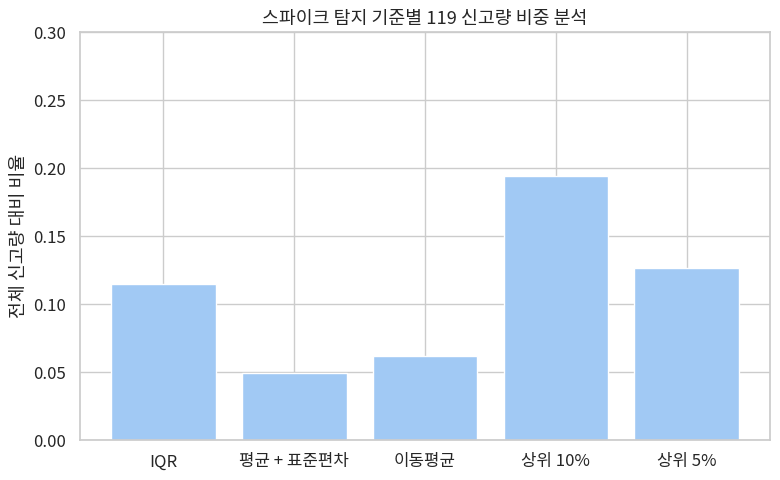

In [22]:
# 전체 신고 건수
total_call_volume = df_call["call_count"].sum()

# is_spike_day 기준별 스파이크 구간의 신고 건수 합계
daily_spike_volumes = {
    "IQR": daily_calls.loc[daily_calls["daily_spike_iqr"], "call_count"].sum(),
    "평균 + 표준편차": daily_calls.loc[daily_calls["daily_spike_mean_std"], "call_count"].sum(),
    "이동평균": daily_calls.loc[daily_calls["daily_spike_moving_avg"], "call_count"].sum(),
    "상위 10%": daily_calls.loc[daily_calls["daily_spike_top10pct"], "call_count"].sum(),
    "상위 5%": daily_calls.loc[daily_calls["daily_spike_top5pct"], "call_count"].sum(),
}

# 비율 계산
daily_spike_ratios = {k: v / total_call_volume for k, v in daily_spike_volumes.items()}

# 시각화
plt.figure(figsize=(8, 5))
plt.bar(daily_spike_ratios.keys(), daily_spike_ratios.values())
plt.title("스파이크 탐지 기준별 119 신고량 비중 분석")
plt.ylabel("전체 신고량 대비 비율")
plt.ylim(0, 0.3)
plt.tight_layout()
plt.show()

- 비율이 높을수록: 해당 기준은 많은 신고량을 커버함 → 민감한 기준

- 비율이 낮을수록: 더 엄격한 기준 → 소수의 고신고 구간만 탐지

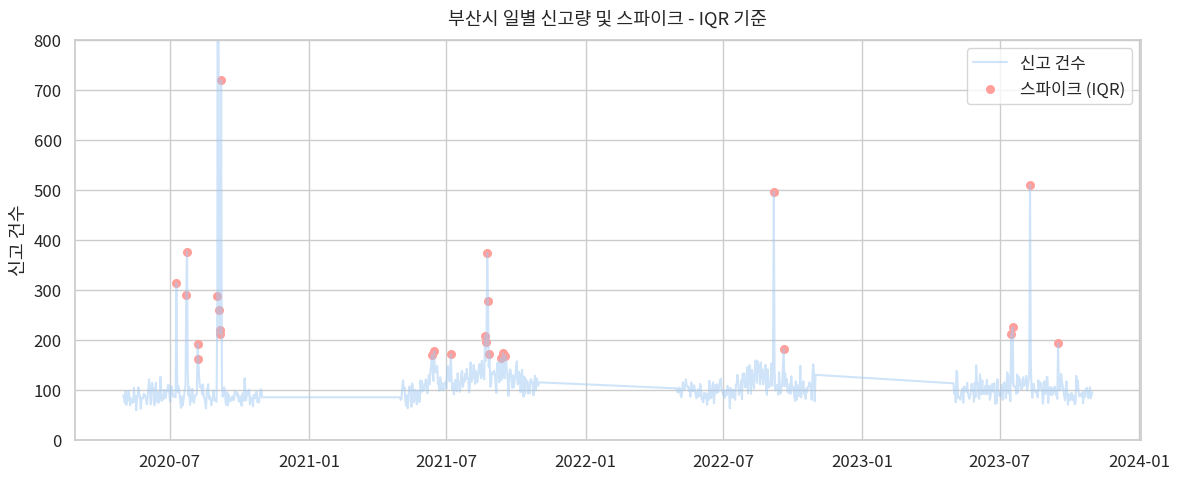

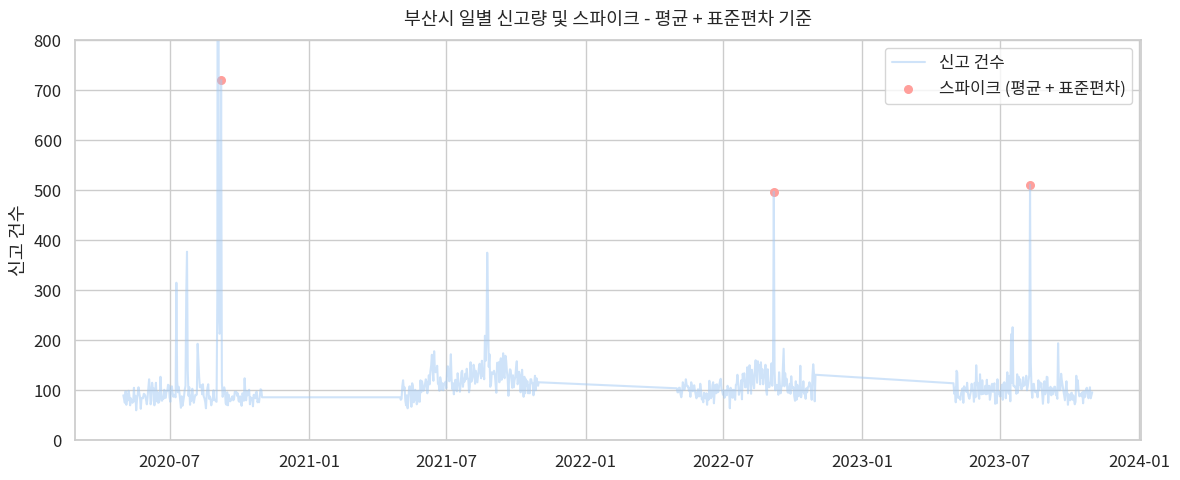

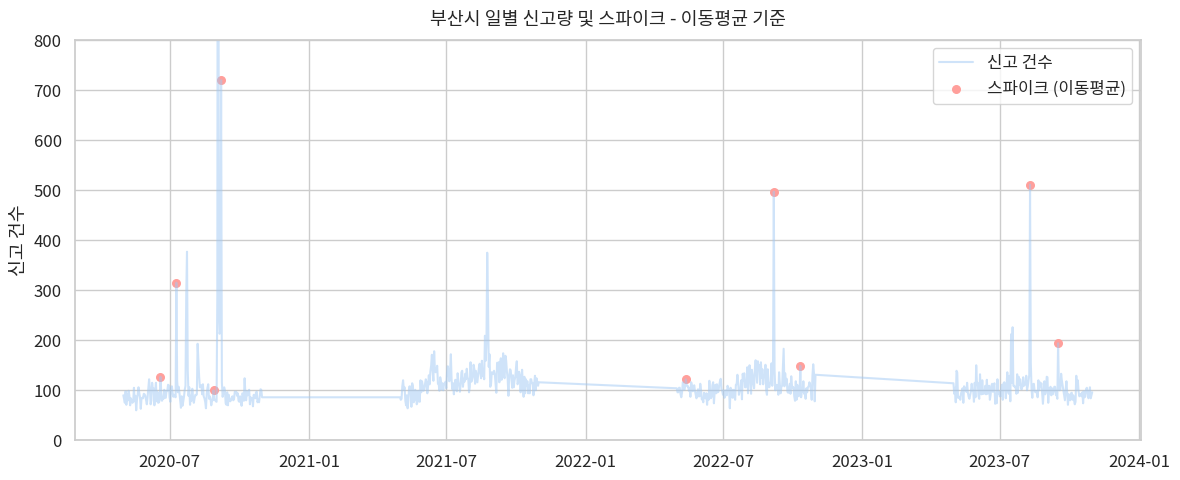

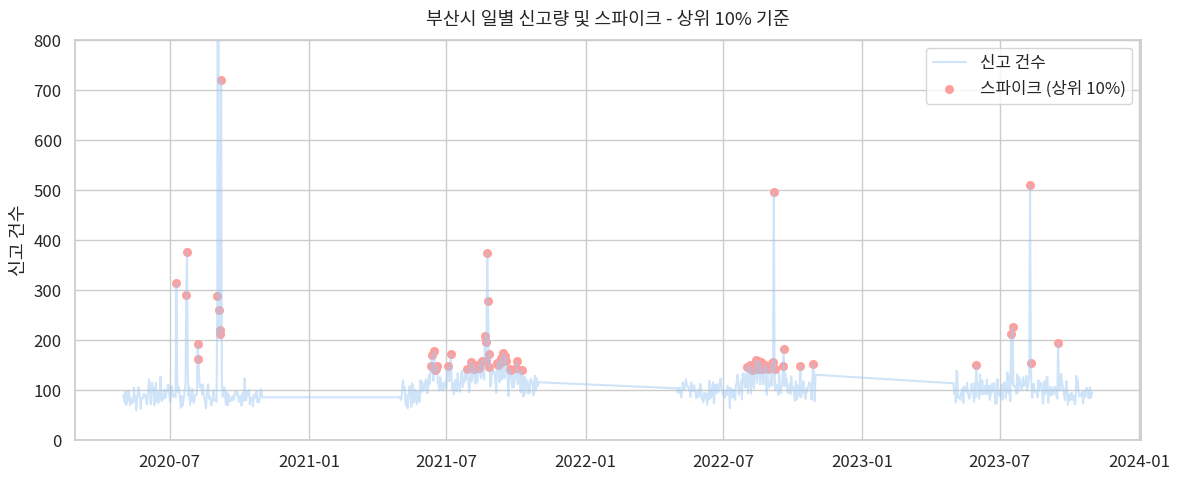

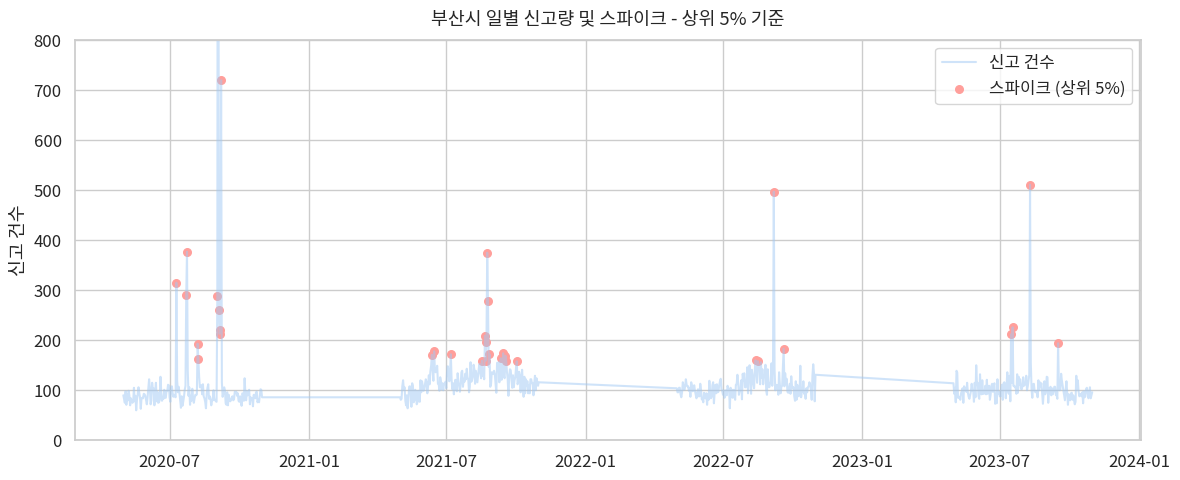

In [23]:
# is_spike_day 기준별 스파이크 날짜 추출
daily_spike_dates = {
    "IQR": daily_calls.loc[daily_calls["daily_spike_iqr"]].index,
    "평균 + 표준편차": daily_calls.loc[daily_calls["daily_spike_mean_std"]].index,
    "이동평균": daily_calls.loc[daily_calls["daily_spike_moving_avg"]].index,
    "상위 10%": daily_calls.loc[daily_calls["daily_spike_top10pct"]].index,
    "상위 5%": daily_calls.loc[daily_calls["daily_spike_top5pct"]].index,
}

# 시각화
for label, dates in daily_spike_dates.items():
    plt.figure(figsize=(12, 5))
    sns.lineplot(x=daily_calls.index, y=daily_calls["call_count"], label="신고 건수", alpha=0.5)
    plt.scatter(dates, daily_calls.loc[dates, "call_count"], color=sns.color_palette("pastel")[3], label=f"스파이크 ({label})", s=30)
    plt.title(f"부산시 일별 신고량 및 스파이크 - {label} 기준", y=1.02)
    plt.xlabel("")
    plt.ylabel("신고 건수")
    plt.ylim(0, 800)
    plt.legend()
    plt.tight_layout()
    plt.show()

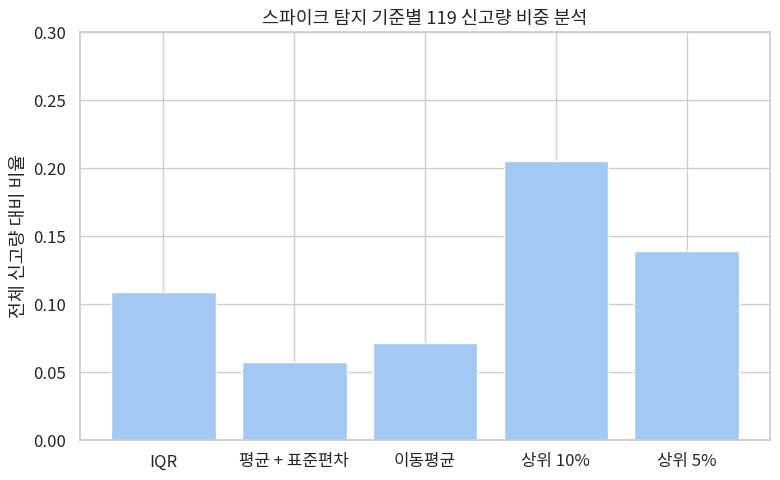

In [24]:
# 전체 신고 건수
total_call_volume = df_call["call_count"].sum()

# is_spike_local 기준별 스파이크 구간의 신고 건수 합계
local_spike_volumes = {
    "IQR": local_calls.loc[local_calls["local_spike_iqr"], "call_count"].sum(),
    "평균 + 표준편차": local_calls.loc[local_calls["local_spike_mean_std"], "call_count"].sum(),
    "이동평균": local_calls.loc[local_calls["local_spike_moving_avg"], "call_count"].sum(),
    "상위 10%": local_calls.loc[local_calls["local_spike_top10pct"], "call_count"].sum(),
    "상위 5%": local_calls.loc[local_calls["local_spike_top5pct"], "call_count"].sum(),
}

# 비율 계산
local_spike_ratios = {k: v / total_call_volume for k, v in local_spike_volumes.items()}

# 시각화
plt.figure(figsize=(8, 5))
plt.bar(local_spike_ratios.keys(), local_spike_ratios.values())
plt.title("스파이크 탐지 기준별 119 신고량 비중 분석")
plt.ylabel("전체 신고량 대비 비율")
plt.ylim(0, 0.3)
plt.tight_layout()
plt.show()